# Mammographic Mass Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn.model_selection import train_test_split
from collections import Counter

!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.base import clone
from itertools import combinations

from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

## Data Importing, Cleansing & Preprocessing

In [2]:
url_mammo = 'http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data'

columns = ['Assessment', 'Age', 'Shape', 'Margin', 'Density', 'Severity']

df_mammo = pd.read_csv(url_mammo, names = columns, header = None)

In [3]:
df_mammo.head()

,Assessment,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1


In [4]:
df_mammo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
Assessment    961 non-null object
Age           961 non-null object
Shape         961 non-null object
Margin        961 non-null object
Density       961 non-null object
Severity      961 non-null int64
dtypes: int64(1), object(5)
memory usage: 45.1+ KB


In [5]:
df_mammo.Severity.value_counts() # 0 is benign, while 1 is malignant

0    516
1    445
Name: Severity, dtype: int64

### Imputate Missing Data

In [6]:
df_mammo = df_mammo[~df_mammo.isin(['?'])]
df_mammo.isna().values.any() #test whether there is any missing data

True

In [7]:
df_mammo.isna().sum() #count how many missing data each feature has

Assessment     2
Age            5
Shape         31
Margin        48
Density       76
Severity       0
dtype: int64

In [8]:
df_mammo.Assessment.value_counts() #count the number of each value of Assessment

4     547
5     345
3      36
2      14
6      11
0       5
55      1
Name: Assessment, dtype: int64

In [9]:
df_mammo.Assessment.fillna(value = 4, inplace = True) #impute the missing data with the mode of Assessment

In [10]:
df_mammo.Age.fillna(value = df_mammo['Age'].median(), inplace = True) #impute the missing data with the median of Assessment

In [11]:
df_mammo.Shape.value_counts() #count the number of each value of Shape

4    400
1    224
2    211
3     95
Name: Shape, dtype: int64

In [12]:
df_mammo.Shape.fillna(value = 4, inplace = True) #impute the missing data with the mode of Shape

In [13]:
df_mammo.Margin.value_counts() #count the number of each value of Margin

1    357
4    280
5    136
3    116
2     24
Name: Margin, dtype: int64

In [14]:
df_mammo.Margin.fillna(value = 1, inplace = True) #impute the missing data with the mode of Margin

In [15]:
df_mammo.Density.value_counts() #count the number of each value of Density

3    798
2     59
1     16
4     12
Name: Density, dtype: int64

In [16]:
df_mammo.Density.fillna(value = 3, inplace = True) #impute the missing data with the mode of Density

In [17]:
df_mammo.isna().values.any() #test whether there is any missing data

False

### Convert Data Type

In [18]:
df_mammo['Assessment']=df_mammo['Assessment'].astype('int') #convert the type of each feature to integer
df_mammo['Age']=df_mammo['Age'].astype('int')
df_mammo['Shape']=df_mammo['Shape'].astype('int')
df_mammo['Margin']=df_mammo['Margin'].astype('int')
df_mammo['Density']=df_mammo['Density'].astype('int')

df_mammo.head()

,Assessment,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,3,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,3,1


In [19]:
df_mammo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
Assessment    961 non-null int64
Age           961 non-null int64
Shape         961 non-null int64
Margin        961 non-null int64
Density       961 non-null int64
Severity      961 non-null int64
dtypes: int64(6)
memory usage: 45.1 KB


In [20]:
df_mammo.describe()

,Assessment,Age,Shape,Margin,Density,Severity
count,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000
mean,4.347555,55.495317,2.762747,2.706556,2.917794,0.463059
std,1.781244,14.442783,1.243276,1.576272,0.365869,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


### Feature engineering - Standardise Continuous Feature

In [21]:
s_scaler = StandardScaler()
Age_ss = s_scaler.fit_transform(df_mammo[['Age']])
df_mammo.insert(2, 'Age_ss', Age_ss)

mean_age = df_mammo['Age_ss'].mean()
std_age = df_mammo['Age_ss'].std()

cut_off = std_age * 3

upper, lower = mean_age + cut_off , mean_age - cut_off

age_3σ = df_mammo[(df_mammo['Age_ss'] > upper) & (df_mammo['Age_ss'] < lower) ] # to see whether there is any outlier within Age column when Standard Deviation (σ) is 3
age_3σ # age_3σ is empty -> Age_ss has no outliers

,Assessment,Age,Age_ss,Shape,Margin,Density,Severity


In [22]:
age_3σ.values in df_mammo['Age_ss'].values # Make sure Age_ss has no outliers

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

### Feature engineering - Remove and Fix Outliers

In [23]:
df_mammo.Assessment.unique() #see what values df_mammo.Assessment has

array([ 5,  4,  3,  2, 55,  0,  6])

In [24]:
df_mammo.Assessment.value_counts() 

4     549
5     345
3      36
2      14
6      11
0       5
55      1
Name: Assessment, dtype: int64

In [25]:
print(df_mammo[df_mammo.Assessment== 55].index) #replace 55 with 5
df_mammo.iloc[340,0]=5

Int64Index([340], dtype='int64')


In [26]:
mask_1 = df_mammo[df_mammo.Assessment== 0 ] 
mask_2 = df_mammo[df_mammo.Assessment== 6 ]

In [27]:
mask = pd.concat([mask_1, mask_2]) #delete observations with df_mammo.Assessment being 0 and 6
mask

,Assessment,Age,Age_ss,Shape,Margin,Density,Severity
456,0,69,0.935534,4,5,3,1
533,0,58,0.173511,4,4,3,0
799,0,72,1.143358,4,3,3,1
893,0,45,-0.727061,2,4,3,0
950,0,71,1.074084,4,4,3,1
550,6,80,1.697557,4,5,3,1
664,6,60,0.312061,3,5,3,1
692,6,51,-0.311412,4,4,3,1
707,6,41,-1.004160,2,1,3,0
717,6,71,1.074084,4,4,3,1


In [28]:
len(mask)

16

In [29]:
mask_index = mask.index
df_mammo_dropped = df_mammo.drop(index = mask_index).drop(columns = 'Age') # dropping Age column is because it is principally same as Age_ss

df_mammo_dropped.Assessment.unique() #see what values df_mammo.Assessment has

array([5, 4, 3, 2])

In [30]:
df_mammo_dropped.describe()

,Assessment,Age_ss,Shape,Margin,Density,Severity
count,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000
mean,4.298413,-0.006603,2.752381,2.696296,2.916402,0.459259
std,0.612241,1.000699,1.245355,1.578402,0.365915,0.498601
min,2.000000,-2.597480,1.000000,1.000000,1.000000,0.000000
25%,4.000000,-0.727061,2.000000,1.000000,3.000000,0.000000
50%,4.000000,0.104237,3.000000,3.000000,3.000000,0.000000
75%,5.000000,0.727710,4.000000,4.000000,3.000000,1.000000
max,5.000000,2.805953,4.000000,5.000000,4.000000,1.000000


In [31]:
df_mammo_dropped.Severity.value_counts() # 0 is benign, while 1 is malignant

0    511
1    434
Name: Severity, dtype: int64

##### Exploratory Data Analysis

Assessment       AxesSubplot(0.125,0.536818;0.227941x0.343182)
Age_ss        AxesSubplot(0.398529,0.536818;0.227941x0.343182)
Shape         AxesSubplot(0.672059,0.536818;0.227941x0.343182)
Margin              AxesSubplot(0.125,0.125;0.227941x0.343182)
Density          AxesSubplot(0.398529,0.125;0.227941x0.343182)
Severity         AxesSubplot(0.672059,0.125;0.227941x0.343182)
dtype: object

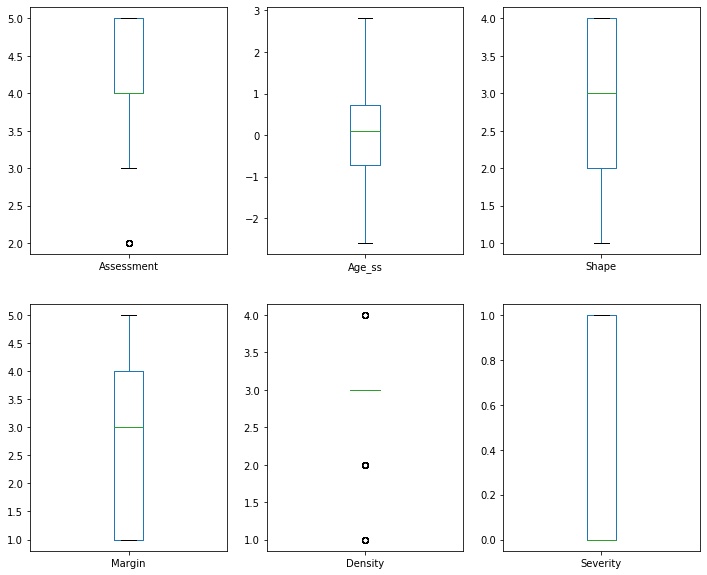

In [32]:
df_mammo_dropped.plot(kind= 'box' , subplots=True, layout=(2,3), sharex=False, sharey=False, figsize=(12,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a266d28d0>,
      dtype=object)

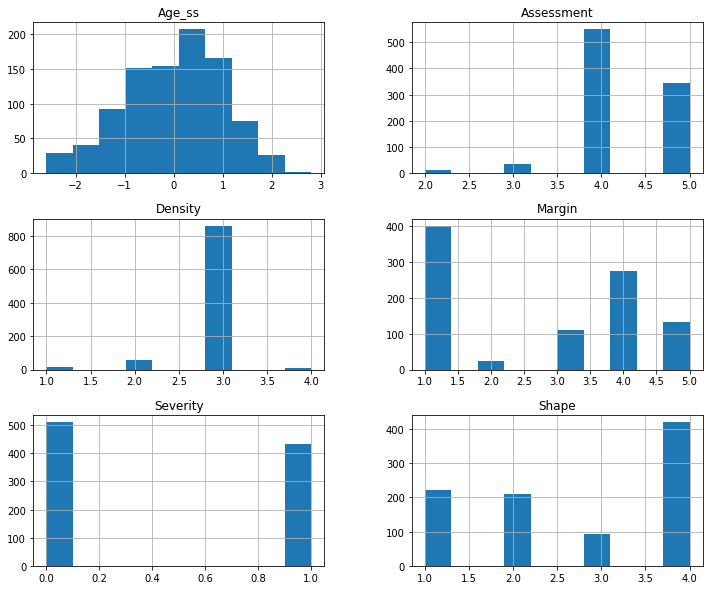

In [33]:
df_mammo_dropped.hist(figsize=(12,10))

In [34]:
corr = df_mammo_dropped.corr()
corr

,Assessment,Age_ss,Shape,Margin,Density,Severity
Assessment,1.000000,0.345704,0.431851,0.495091,0.087830,0.584687
Age_ss,0.345704,1.000000,0.354701,0.391047,0.020161,0.432467
Shape,0.431851,0.354701,1.000000,0.716177,0.042862,0.536483
Margin,0.495091,0.391047,0.716177,1.000000,0.084384,0.569114
Density,0.087830,0.020161,0.042862,0.084384,1.000000,0.053890
Severity,0.584687,0.432467,0.536483,0.569114,0.053890,1.000000


In [35]:
plt.rcParams['figure.figsize']=(10,5)

Text(0.5, 1, 'Correlation Matrix for Mammographic Mass Dataset')

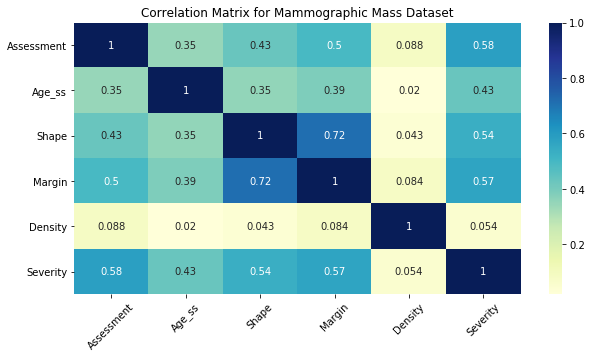

In [36]:
ax = sns.heatmap(corr, annot = True, cmap="YlGnBu")     
plt.setp(ax.axes.get_xticklabels(), rotation=45)

plt.title('Correlation Matrix for Mammographic Mass Dataset')

## Exploring Feature Space

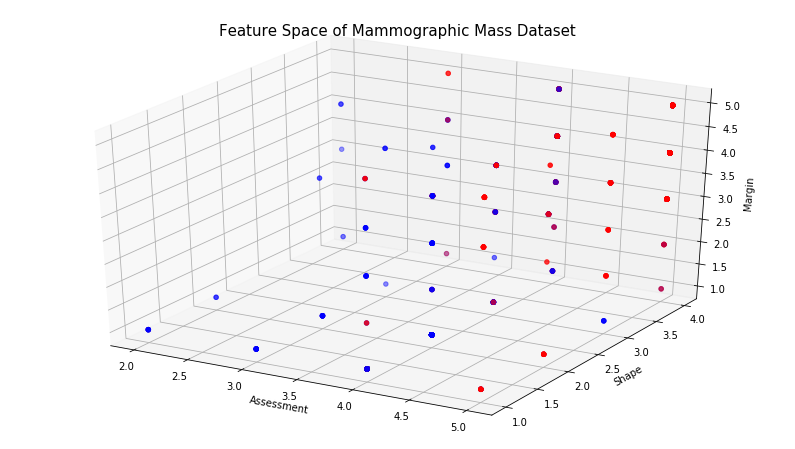

In [37]:
feature1 = df_mammo_dropped['Assessment'].values
feature2 = df_mammo_dropped['Shape'].values 
feature3 = df_mammo_dropped['Margin'].values

df_mammo_dropped['Severity'] = df_mammo_dropped['Severity'].astype('str')
c = df_mammo_dropped['Severity'].values
df_mammo_dropped['Severity'] = df_mammo_dropped['Severity'].astype('int')

c[c=='0'] = 'b' #benign
c[c=='1'] = 'r' #malignant

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feature1, feature2, feature3, color = c)
ax.set_title('Feature Space of Mammographic Mass Dataset', fontsize=15)
ax.set_xlabel('Assessment')
ax.set_ylabel('Shape')
ax.set_zlabel('Margin')


plt.show()

## Data Split Into Training and Test Sets

In [38]:
# transfer adjusted data into new X and y arrays

X = np.array(df_mammo_dropped.iloc[:, :-1].values)
y = np.array(df_mammo_dropped.iloc[:, -1].values) # class label is contained here

np.mean(y), np.std(y), np.var(y)

(0.45925925925925926, 0.4983374278979011, 0.2483401920438958)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19, stratify = y)

### Oversampling The Minority Class of The Training Set With SMOTE

In [40]:
print('Original dataset shape %s' % Counter(y_train))

smote = SMOTE(sampling_strategy ='minority', random_state = 19) #oversampling

X_train, y_train = smote.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train))

Original dataset shape Counter({0: 357, 1: 304})
Resampled dataset shape Counter({0: 357, 1: 357})


In [41]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(714, 5)
(714,)
(284, 5)
(284,)


In [42]:
# Saving preprocessed data to files for transfer to UCL servers
np.save('X_train', X_train) # save the file as "X_train.npy"
np.save('y_train', y_train) # save the file as "y_train.npy" 
np.save('X_test', X_test) # save the file as "X_test.npy"
np.save('y_test', y_test) # save the file as "y_test.npy"

## Build Complex Functions In Advance

### Sequential Backward Selection

In [43]:
class SBS(): # from practical lectures at UCL
    def __init__(self, estimator, k_features, scoring=roc_auc_score,
                 test_size=0.3, random_state=19):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
                train_test_split(X, y, test_size=self.test_size, 
                                 random_state=self.random_state)

        dim = X_train.shape[1]
        
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score
    
X_train.shape[1]

5

### Training Metrics

In [44]:
plt.rcParams['figure.figsize']=(7,7)

def training_metrics(clf, X_train, y_train, prediction):
    
    # training metrics
    print("Evaluation parameters on training data:")
    print("\n")

    print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_train, prediction)))
    print("AUC: {0:.4f}".format(metrics.roc_auc_score(y_train, prediction)))
    print("Precision: {0:.4f}".format(metrics.precision_score(y_train, prediction)))
    print("Recall: {0:.4f}".format(metrics.recall_score(y_train, prediction)))
    print("F1: {0:.4f}".format(metrics.f1_score(y_train, prediction)))

    print("\n")
    print("Confusion Matrix")
    print(confusion_matrix(y_train, prediction))

    tr_probas = clf.predict_proba(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, tr_probas[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    current_auc = str('%.4f' %roc_auc)
    fig = plt.figure(figsize=(5, 5))    
    plt.plot(fpr, tpr, lw=1, label= str('Classifier on training data' + ' AUC: ' + current_auc))

    plt.plot([0, 1], 
             [0, 1], 
             linestyle='--', 
             color=(0.6, 0.6, 0.6), 
             label='random guessing')

    plt.plot([0, 0, 1], 
             [0, 1, 1], 
             lw=2, 
             linestyle=':', 
             color='black', 
             label='perfect performance')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('Receiver Operator Characteristic')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

### Testing Metrics

In [45]:
def testing_metrics(clf, X_test, y_test, prediction):
    
    # training metrics
    print("Evaluation parameters on testing data:")
    print("\n")

    print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, prediction)))
    print("AUC: {0:.4f}".format(metrics.roc_auc_score(y_test, prediction)))
    print("Precision: {0:.4f}".format(metrics.precision_score(y_test, prediction)))
    print("Recall: {0:.4f}".format(metrics.recall_score(y_test, prediction)))
    print("F1: {0:.4f}".format(metrics.f1_score(y_test, prediction)))

    print("\n")
    print("Confusion Matrix")
    print(confusion_matrix(y_test, prediction))

    tr_probas = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, tr_probas[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    current_auc = str('%.4f' %roc_auc)
    fig = plt.figure(figsize=(5, 5))    
    plt.plot(fpr, tpr, lw=1, label= str('Classifier on testing data' + ' AUC: ' + current_auc))

    plt.plot([0, 1], 
             [0, 1], 
             linestyle='--', 
             color=(0.6, 0.6, 0.6), 
             label='random guessing')

    plt.plot([0, 0, 1], 
             [0, 1, 1], 
             lw=2, 
             linestyle=':', 
             color='black', 
             label='perfect performance')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('Receiver Operator Characteristic')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

## Decision Tree

In [46]:
dt = DecisionTreeClassifier(random_state=19)

# selecting features
sbs_dt = SBS(dt, k_features=1)
sbs_dt.fit(X_train, y_train)

# plotting performance of feature subsets
dt_feat = [len(k) for k in sbs_dt.subsets_]

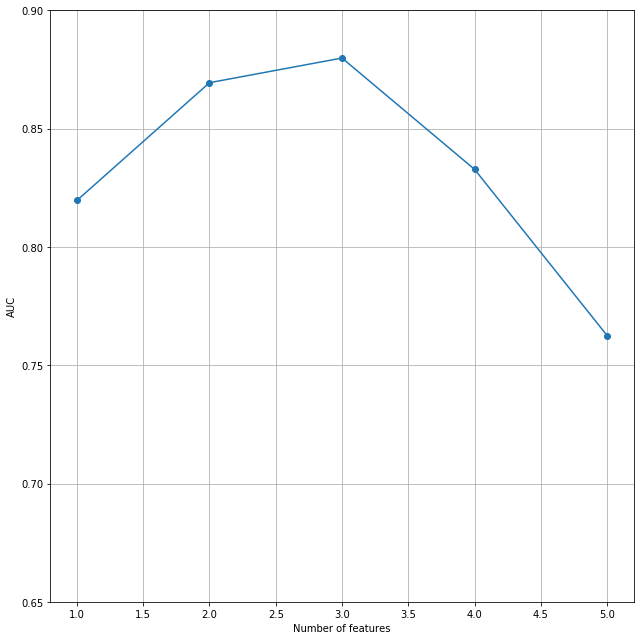

In [47]:
plt.rcParams['figure.figsize']=(9,9)
plt.plot(dt_feat, sbs_dt.scores_, marker='o')
plt.ylim([0.65, 0.9])
plt.ylabel('AUC')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [48]:
sbs_dt.subsets_

[(0, 1, 2, 3, 4), (0, 2, 3, 4), (0, 3, 4), (0, 3), (0,)]

In [49]:
dt_3=list(sbs_dt.subsets_[-3])
print(dt_3)

feature_labels = df_mammo_dropped.columns[0:-1]
print (feature_labels[dt_3])

[0, 3, 4]
Index(['Assessment', 'Margin', 'Density'], dtype='object')


In [50]:
features_selected = ['Assessment', 'Margin', 'Density', 'Severity']

dt_df_mammo = df_mammo_dropped.loc[:, features_selected]
dt_df_mammo.head()

,Assessment,Margin,Density,Severity
0,5,5,3,1
1,4,1,3,1
2,5,5,3,1
3,4,1,3,0
4,5,5,3,1


In [51]:
dt_X = np.array(dt_df_mammo.iloc[:, :-1].values)
dt_y = np.array(dt_df_mammo.iloc[:, -1].values)

In [52]:
dt_X_train, dt_X_test, dt_y_train, dt_y_test = train_test_split(dt_X, dt_y, test_size=0.3, random_state=19, stratify = y)

In [53]:
print('Original dataset shape %s' % Counter(dt_y_train))

smote_dt = SMOTE(sampling_strategy ='minority', random_state = 19) #oversampling
              
dt_X_train, dt_y_train = smote_dt.fit_resample(dt_X_train, dt_y_train)

print('Resampled dataset shape %s' % Counter(dt_y_train))

Original dataset shape Counter({0: 357, 1: 304})
Resampled dataset shape Counter({0: 357, 1: 357})


In [54]:
print(dt_X_train.shape)
print(dt_y_train.shape)
print(dt_X_test.shape)
print(dt_y_test.shape)

(714, 3)
(714,)
(284, 3)
(284,)


In [55]:
# Saving preprocessed data to files for transfer to UCL servers
np.save('dt_X_train', dt_X_train) # save the file as "dt_X_train.npy"
np.save('dt_y_train', dt_y_train) # save the file as "dt_y_train.npy" 
np.save('dt_X_test', dt_X_test) # save the file as "dt_X_test.npy"
np.save('dt_y_test', dt_y_test) # save the file as "dt_y_test.npy"

### Base Decision Tree

In [56]:
base_dt = DecisionTreeClassifier(random_state=19)

In [57]:
base_dt

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=19, splitter='best')

In [58]:
base_dt.fit(dt_X_train, dt_y_train)  

base_dt_training_prediction = base_dt.predict(dt_X_train)

base_dt_testing_prediction = base_dt.predict(dt_X_test)
#base_dt_testing_prediction

Evaluation parameters on training data:


Accuracy: 0.8375
AUC: 0.8375
Precision: 0.8163
Recall: 0.8711
F1: 0.8428


Confusion Matrix
[[287  70]
 [ 46 311]]


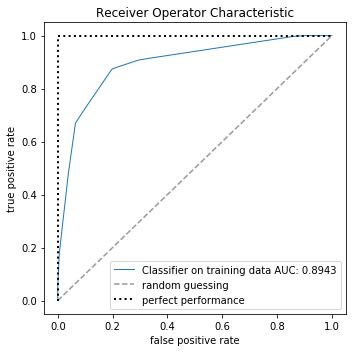

In [59]:
training_metrics(base_dt, dt_X_train, dt_y_train, base_dt_training_prediction)

In [60]:
tn, fp, fn, tp = confusion_matrix(dt_y_train, base_dt_training_prediction).ravel()
(tp, fn, fp, tn)

(311, 46, 70, 287)

Evaluation parameters on testing data:


Accuracy: 0.8028
AUC: 0.8062
Precision: 0.7534
Recall: 0.8462
F1: 0.7971


Confusion Matrix
[[118  36]
 [ 20 110]]


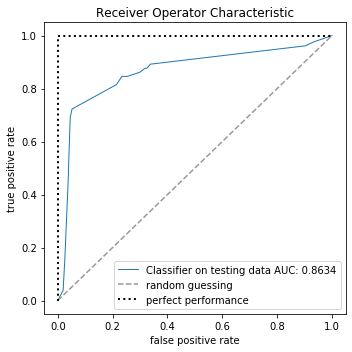

In [61]:
testing_metrics(base_dt, dt_X_test, dt_y_test, base_dt_testing_prediction)

In [62]:
tn, fp, fn, tp = confusion_matrix(dt_y_test, base_dt_testing_prediction).ravel()
(tp, fn, fp, tn)

(110, 20, 36, 118)

### Decision Tree Hyperparameter tunning with GridsearchCV

In [63]:
hyperparameters_dt={'criterion': ['gini', 'entropy'],
            'max_depth': [None, 5, 10],
            'min_samples_leaf': [1, 5, 10],
            'min_samples_split': [2, 5, 10],
            'random_state' : [19],
            'class_weight': ['balanced', 'None']}

dt_gscv = GridSearchCV(estimator = DecisionTreeClassifier(),
                   param_grid = hyperparameters_dt,
                   n_jobs=3,
                   scoring='roc_auc',
                   verbose=2,
                   cv=10)

dt_gsCV = dt_gscv.fit(dt_X_train, dt_y_train)
print('--> Tuned Parameters Best Score: ',dt_gsCV.best_score_)
print('--> Best Parameters: \n',dt_gsCV.best_params_)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 280 tasks      | elapsed:    2.5s


--> Tuned Parameters Best Score:  0.8785934744268078
--> Best Parameters: 
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2, 'random_state': 19}


[Parallel(n_jobs=3)]: Done 1080 out of 1080 | elapsed:    3.1s finished


In [64]:
best_dt  = DecisionTreeClassifier(class_weight = 'balanced',
                                  criterion = 'entropy',
                                  max_depth = None,
                                  min_samples_leaf = 10,
                                  min_samples_split = 2,
                                  random_state = 19,
                                 )

best_dt.fit(dt_X_train, dt_y_train)  

best_dt_training_prediction = base_dt.predict(dt_X_train)

best_dt_testing_prediction = best_dt.predict(dt_X_test)
# best_dt_testing_prediction

In [65]:
best_dt

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=10,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=19, splitter='best')

Evaluation parameters on training data:


Accuracy: 0.8375
AUC: 0.8375
Precision: 0.8163
Recall: 0.8711
F1: 0.8428


Confusion Matrix
[[287  70]
 [ 46 311]]


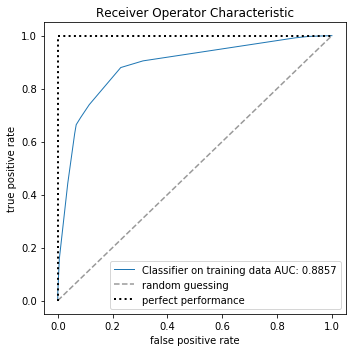

In [66]:
training_metrics(best_dt, dt_X_train, dt_y_train, best_dt_training_prediction)

In [67]:
tn, fp, fn, tp = confusion_matrix(dt_y_train, best_dt_training_prediction).ravel()
(tp, fn, fp, tn)

(311, 46, 70, 287)

Evaluation parameters on testing data:


Accuracy: 0.7923
AUC: 0.7971
Precision: 0.7351
Recall: 0.8538
F1: 0.7900


Confusion Matrix
[[114  40]
 [ 19 111]]


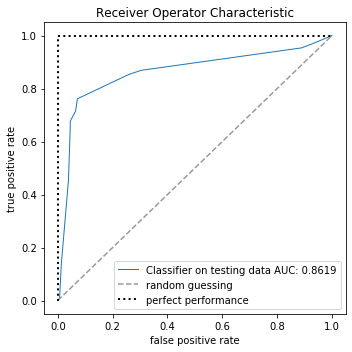

In [68]:
testing_metrics(best_dt, dt_X_test, dt_y_test, best_dt_testing_prediction)

In [69]:
tn, fp, fn, tp = confusion_matrix(dt_y_test, best_dt_testing_prediction).ravel()
(tp, fn, fp, tn)

(111, 19, 40, 114)

### Sensitivity Analysis

In [70]:
sens_dt  = DecisionTreeClassifier(class_weight = 'balanced',
                                  criterion = 'entropy',
                                  max_depth = None,
                                  min_samples_leaf = 20,
                                  min_samples_split = 10,
                                  random_state = 19
                                 )

sens_dt.fit(dt_X_train, dt_y_train)  

sens_dt_training_prediction = sens_dt.predict(dt_X_train)

sens_dt_testing_prediction = sens_dt.predict(dt_X_test)
# best_dt_testing_prediction

In [71]:
sens_dt

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=20,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=19, splitter='best')

Evaluation parameters on training data:


Accuracy: 0.8249
AUC: 0.8249
Precision: 0.7929
Recall: 0.8796
F1: 0.8340


Confusion Matrix
[[275  82]
 [ 43 314]]


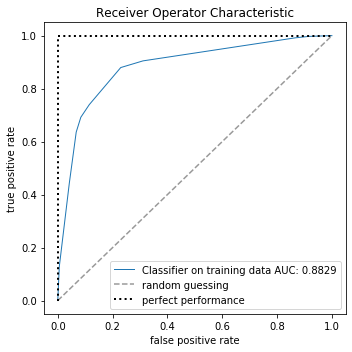

In [72]:
training_metrics(sens_dt, dt_X_train, dt_y_train, sens_dt_training_prediction)

In [73]:
tn, fp, fn, tp = confusion_matrix(dt_y_train, sens_dt_training_prediction).ravel()
(tp, fn, fp, tn)

(314, 43, 82, 275)

Evaluation parameters on testing data:


Accuracy: 0.7923
AUC: 0.7971
Precision: 0.7351
Recall: 0.8538
F1: 0.7900


Confusion Matrix
[[114  40]
 [ 19 111]]


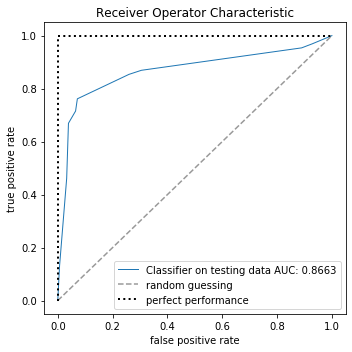

In [74]:
testing_metrics(sens_dt, dt_X_test, dt_y_test, sens_dt_testing_prediction)

In [75]:
tn, fp, fn, tp = confusion_matrix(dt_y_test, sens_dt_testing_prediction).ravel()
(tp, fn, fp, tn)

(111, 19, 40, 114)

## Support Vector Machine  (SVM) Classification

In [76]:
svm = SVC()

# selecting features
sbs_svm = SBS(svm, k_features=1)
sbs_svm.fit(X_train, y_train)

# plotting performance of feature subsets
svm_feat = [len(k) for k in sbs_svm.subsets_]

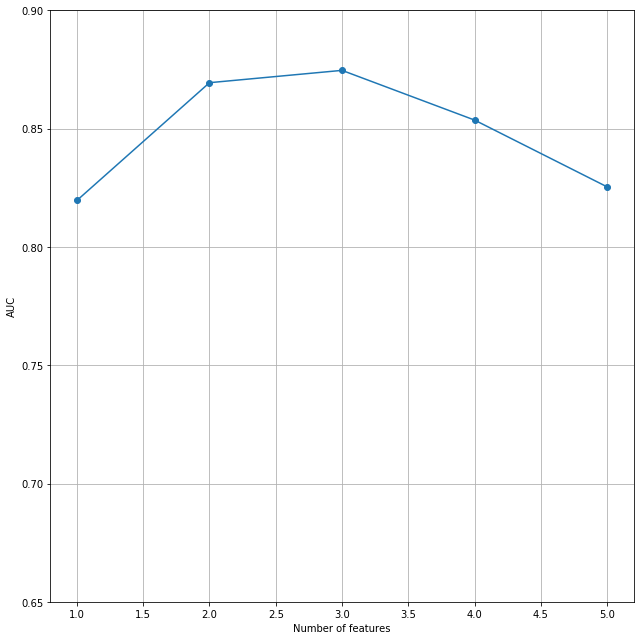

In [77]:
plt.rcParams['figure.figsize']=(9,9)
plt.plot(svm_feat, sbs_svm.scores_, marker='o')
plt.ylim([0.65, 0.9])
plt.ylabel('AUC')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [78]:
sbs_svm.subsets_

[(0, 1, 2, 3, 4), (0, 1, 3, 4), (0, 3, 4), (0, 3), (0,)]

In [79]:
svm_3=list(sbs_svm.subsets_[-3])
print(svm_3)

feature_labels = df_mammo_dropped.columns[0:-1]
print (feature_labels[svm_3])

[0, 3, 4]
Index(['Assessment', 'Margin', 'Density'], dtype='object')


In [80]:
features_selected = ['Assessment', 'Margin', 'Density', 'Severity']

svm_df_mammo = df_mammo_dropped.loc[:, features_selected]
svm_df_mammo.head()

,Assessment,Margin,Density,Severity
0,5,5,3,1
1,4,1,3,1
2,5,5,3,1
3,4,1,3,0
4,5,5,3,1


In [81]:
svm_X = np.array(svm_df_mammo.iloc[:, :-1].values)
svm_y = np.array(svm_df_mammo.iloc[:, -1].values)

In [82]:
svm_X_train, svm_X_test, svm_y_train, svm_y_test = train_test_split(svm_X, svm_y, test_size=0.3, random_state=19, stratify = y)

In [83]:
print('Original dataset shape %s' % Counter(svm_y_train))

smote_svm = SMOTE(sampling_strategy ='minority', random_state = 19) #oversampling
              
svm_X_train, svm_y_train = smote_svm.fit_resample(svm_X_train, svm_y_train)

print('Resampled dataset shape %s' % Counter(svm_y_train))

Original dataset shape Counter({0: 357, 1: 304})
Resampled dataset shape Counter({0: 357, 1: 357})


In [84]:
print(svm_X_train.shape)
print(svm_y_train.shape)
print(svm_X_test.shape)
print(svm_y_test.shape)

(714, 3)
(714,)
(284, 3)
(284,)


In [85]:
# Saving preprocessed data to files for transfer to UCL servers
np.save('svm_X_train', svm_X_train) # save the file as "svm_X_train.npy"
np.save('svm_y_train', svm_y_train) # save the file as "svm_y_train.npy" 
np.save('svm_X_test', svm_X_test) # save the file as "svm_X_test.npy"
np.save('svm_y_test', svm_y_test) # save the file as "svm_y_test.npy"

### Base SVM

In [86]:
base_svm = SVC(probability=True)

In [87]:
base_svm

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [88]:
base_svm.fit(svm_X_train, svm_y_train)  

base_svm_training_prediction = base_svm.predict(svm_X_train)

base_svm_testing_prediction = base_svm.predict(svm_X_test)

Evaluation parameters on training data:


Accuracy: 0.8361
AUC: 0.8361
Precision: 0.8125
Recall: 0.8739
F1: 0.8421


Confusion Matrix
[[285  72]
 [ 45 312]]


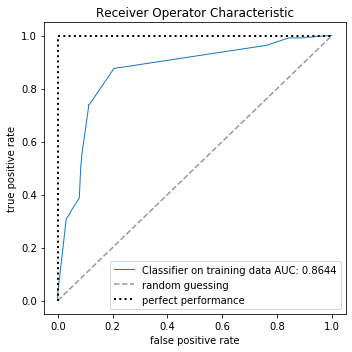

In [89]:
training_metrics(base_svm, svm_X_train, svm_y_train, base_svm_training_prediction)

In [90]:
tn, fp, fn, tp = confusion_matrix(svm_y_train, base_svm_training_prediction).ravel()
(tp, fn, fp, tn)

(312, 45, 72, 285)

Evaluation parameters on testing data:


Accuracy: 0.8063
AUC: 0.8100
Precision: 0.7551
Recall: 0.8538
F1: 0.8014


Confusion Matrix
[[118  36]
 [ 19 111]]


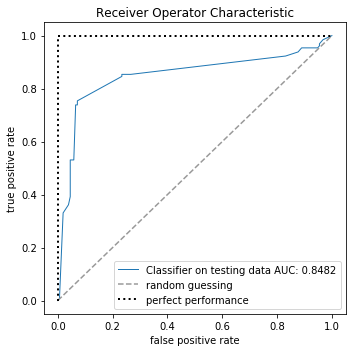

In [91]:
testing_metrics(base_svm, svm_X_test, svm_y_test, base_svm_testing_prediction)

In [92]:
tn, fp, fn, tp = confusion_matrix(svm_y_test, base_svm_testing_prediction).ravel()
(tp, fn, fp, tn)

(111, 19, 36, 118)

### SVM Hyperparameters tunning with GridSearchCV

In [93]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]   

hyperparameters_svm=[{'kernel': ['rbf'], 'gamma': param_range, 'C': param_range, 'shrinking' : [True, False], 'decision_function_shape':['ovo', 'ovr'], 'random_state': [19]},
                                 {'kernel': ['rbf'], 'gamma': ['auto', 'scaled'],  'C': param_range, 'shrinking' : [True, False], 'decision_function_shape':['ovo', 'ovr'],'random_state': [19]},
                                 {'kernel': ['linear'], 'gamma': param_range, 'C': param_range, 'shrinking' : [True, False], 'decision_function_shape':['ovo', 'ovr'],'random_state': [19]},
                                 {'kernel': ['linear'], 'gamma': ['auto', 'scaled'],  'C': param_range, 'shrinking' : [True, False], 'decision_function_shape':['ovo', 'ovr'],'random_state': [19]},
                                 {'kernel': ['sigmoid'], 'gamma': param_range, 'C': param_range, 'shrinking' : [True, False], 'coef0': param_range, 'decision_function_shape':['ovo', 'ovr'],'random_state': [19]},
                                 {'kernel': ['sigmoid'], 'gamma': ['auto', 'scaled'], 'C': param_range, 'shrinking' : [True, False],'coef0': param_range, 'decision_function_shape':['ovo', 'ovr'],'random_state': [19]}] 

In [94]:
svm_gscv = GridSearchCV(estimator = SVC(),
                   param_grid = hyperparameters_svm,
                   n_jobs=3,
                   scoring='roc_auc',
                   verbose=2,
                   cv=10)

svm_gsCV = svm_gscv.fit(svm_X_train, svm_y_train)
print('--> Tuned Parameters Best Score: ',svm_gsCV.best_score_)
print('--> Best Parameters: \n',svm_gsCV.best_params_)

Fitting 10 folds for each of 2268 candidates, totalling 22680 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 296 tasks      | elapsed:    3.2s
[Parallel(n_jobs=3)]: Done 1506 tasks      | elapsed:   12.5s
[Parallel(n_jobs=3)]: Done 5112 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done 8750 tasks      | elapsed:  1.8min
[Parallel(n_jobs=3)]: Done 13130 tasks      | elapsed:  2.2min
[Parallel(n_jobs=3)]: Done 18470 tasks      | elapsed:  2.7min


--> Tuned Parameters Best Score:  0.8805324074074073
--> Best Parameters: 
 {'C': 10.0, 'decision_function_shape': 'ovo', 'gamma': 0.001, 'kernel': 'linear', 'random_state': 19, 'shrinking': True}


[Parallel(n_jobs=3)]: Done 22680 out of 22680 | elapsed:  3.0min finished


In [95]:
#param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]   
param_range_1 = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.0011, 0.0012, 0.0013, 0.0014, 0.0015]

hyperparameters_svm_1=[{'kernel': ['linear'], 'gamma': param_range_1, 'C': param_range_1, 'shrinking' : [True, False], 'decision_function_shape':['ovo', 'ovr'], 'random_state': [19]},
                                    {'kernel': ['linear'], 'gamma': ['auto', 'scaled'], 'C': param_range_1, 'shrinking' : [True, False], 'decision_function_shape':['ovo', 'ovr'],'random_state': [19]}]

In [96]:
svm_gscv = GridSearchCV(estimator = SVC(),
                   param_grid = hyperparameters_svm_1,
                   n_jobs=3,
                   scoring='roc_auc',
                   verbose=2,
                   cv=10)

svm_gsCV = svm_gscv.fit(svm_X_train, svm_y_train)
print('--> Tuned Parameters Best Score: ',svm_gsCV.best_score_)
print('--> Best Parameters: \n',svm_gsCV.best_params_)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 10 folds for each of 2112 candidates, totalling 21120 fits


[Parallel(n_jobs=3)]: Done 702 tasks      | elapsed:    3.1s
[Parallel(n_jobs=3)]: Done 3606 tasks      | elapsed:   16.3s
[Parallel(n_jobs=3)]: Done 8478 tasks      | elapsed:   42.7s
[Parallel(n_jobs=3)]: Done 15270 tasks      | elapsed:  1.2min


--> Tuned Parameters Best Score:  0.8805324074074073
--> Best Parameters: 
 {'C': 10, 'decision_function_shape': 'ovo', 'gamma': 5, 'kernel': 'linear', 'random_state': 19, 'shrinking': True}


[Parallel(n_jobs=3)]: Done 21120 out of 21120 | elapsed:  1.6min finished


In [97]:
#param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]   
#param_range_1 = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009,0.001, 0.0011, 0.0012, 0.0013, 0.0014, 0.0015]
param_range_2 = [9.5, 9.6, 9.7, 9.8, 9.9, 10, 10.1, 10.2, 10.3, 10.4, 10.5, 1, 2, 3, 4, 4.5, 4.6, 4.7, 4.8, 4.9, 5, 5.1, 5.2, 5.3, 5.4, 5.5]

hyperparameters_svm_2=[{'kernel': ['linear'], 'gamma': param_range_2, 'C': param_range_2, 'shrinking' : [True, False], 'decision_function_shape':['ovo', 'ovr'], 'random_state': [19]},
                                    {'kernel': ['linear'], 'gamma': ['auto', 'scaled'],  'C': param_range_2, 'shrinking' : [True, False], 'decision_function_shape':['ovo', 'ovr'],'random_state': [19]}] 

In [98]:
svm_gscv = GridSearchCV(estimator = SVC(),
                   param_grid = hyperparameters_svm_2,
                   n_jobs=3,
                   scoring='roc_auc',
                   verbose=2,
                   cv=10)

svm_gsCV = svm_gscv.fit(svm_X_train, svm_y_train)
print('--> Tuned Parameters Best Score: ',svm_gsCV.best_score_)
print('--> Best Parameters: \n',svm_gsCV.best_params_)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 10 folds for each of 2912 candidates, totalling 29120 fits


[Parallel(n_jobs=3)]: Done 470 tasks      | elapsed:    2.6s
[Parallel(n_jobs=3)]: Done 2406 tasks      | elapsed:   12.3s
[Parallel(n_jobs=3)]: Done 5654 tasks      | elapsed:   28.9s
[Parallel(n_jobs=3)]: Done 10182 tasks      | elapsed:   52.1s
[Parallel(n_jobs=3)]: Done 16022 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done 23142 tasks      | elapsed:  1.8min


--> Tuned Parameters Best Score:  0.8805434303350971
--> Best Parameters: 
 {'C': 4.9, 'decision_function_shape': 'ovo', 'gamma': 9.5, 'kernel': 'linear', 'random_state': 19, 'shrinking': True}


[Parallel(n_jobs=3)]: Done 29120 out of 29120 | elapsed:  2.1min finished


In [99]:
#param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]   
#param_range_1 = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009,0.001, 0.0011, 0.0012, 0.0013, 0.0014, 0.0015]
#param_range_2 = [9.5, 9.6, 9.7, 9.8, 9.9, 10, 10.1, 10.2, 10.3, 10.4, 10.5, 1, 2, 3, 4, 4.5, 4.6, 4.7, 4.8, 4.9, 5, 5.1, 5.2, 5.3, 5.4, 5.5]
param_range_3 = [4.85, 4.86, 4.87, 4.88, 4.89, 4.9, 4.91, 4.92, 4.93, 4.94, 4.95, 9, 9.1, 9.2, 9.3, 9.4, 9.45, 9.46, 9.47, 9.48, 9.49, 9.5, 9.51, 9.52, 9.53, 9.54, 9.55]

hyperparameters_svm_3=[{'kernel': ['linear'], 'gamma': param_range_3, 'C': param_range_3, 'shrinking' : [True, False], 'decision_function_shape':['ovo', 'ovr'], 'random_state': [19]},
                                    {'kernel': ['linear'], 'gamma': ['auto', 'scaled'],  'C': param_range_3, 'shrinking' : [True, False], 'decision_function_shape':['ovo', 'ovr'],'random_state': [19]}] 

In [100]:
svm_gscv = GridSearchCV(estimator = SVC(),
                   param_grid = hyperparameters_svm_3,
                   n_jobs=3,
                   scoring='roc_auc',
                   verbose=2,
                   cv=10)

svm_gsCV = svm_gscv.fit(svm_X_train, svm_y_train)
print('--> Tuned Parameters Best Score: ',svm_gsCV.best_score_) #same as the above one -> choose one
print('--> Best Parameters: \n',svm_gsCV.best_params_)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 10 folds for each of 3132 candidates, totalling 31320 fits


[Parallel(n_jobs=3)]: Done 702 tasks      | elapsed:    3.1s
[Parallel(n_jobs=3)]: Done 2622 tasks      | elapsed: 37.8min
[Parallel(n_jobs=3)]: Done 5058 tasks      | elapsed: 38.1min
[Parallel(n_jobs=3)]: Done 8454 tasks      | elapsed: 38.4min
[Parallel(n_jobs=3)]: Done 12834 tasks      | elapsed: 38.8min
[Parallel(n_jobs=3)]: Done 18174 tasks      | elapsed: 39.4min
[Parallel(n_jobs=3)]: Done 24498 tasks      | elapsed: 40.0min


--> Tuned Parameters Best Score:  0.8805434303350971
--> Best Parameters: 
 {'C': 4.9, 'decision_function_shape': 'ovo', 'gamma': 4.85, 'kernel': 'linear', 'random_state': 19, 'shrinking': True}


[Parallel(n_jobs=3)]: Done 31320 out of 31320 | elapsed: 40.4min finished


In [101]:
best_svm  = SVC(C = 4.9,
                        decision_function_shape = 'ovo',
                        gamma = 9.5, #or 4.85
                        kernel = 'linear',
                        random_state = 19,
                        shrinking = True,
                        probability = True)

best_svm.fit(svm_X_train, svm_y_train)  

best_svm_training_prediction = best_svm.predict(svm_X_train)

best_svm_testing_prediction = best_svm.predict(svm_X_test)
#best_rf_testing_prediction

In [102]:
best_svm

SVC(C=4.9, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=9.5, kernel='linear',
    max_iter=-1, probability=True, random_state=19, shrinking=True, tol=0.001,
    verbose=False)

Evaluation parameters on training data:


Accuracy: 0.8039
AUC: 0.8039
Precision: 0.8917
Recall: 0.6919
F1: 0.7792


Confusion Matrix
[[327  30]
 [110 247]]


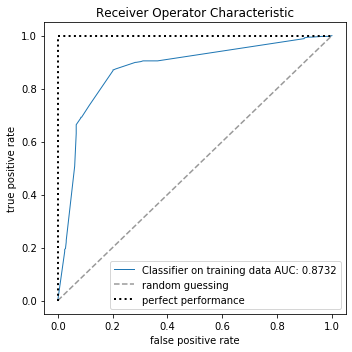

In [103]:
training_metrics(best_svm, svm_X_train, svm_y_train, best_svm_training_prediction)

In [104]:
tn, fp, fn, tp = confusion_matrix(svm_y_train, best_svm_training_prediction).ravel()
(tp, fn, fp, tn)

(247, 110, 30, 327)

Evaluation parameters on testing data:


Accuracy: 0.8345
AUC: 0.8252
Precision: 0.9029
Recall: 0.7154
F1: 0.7983


Confusion Matrix
[[144  10]
 [ 37  93]]


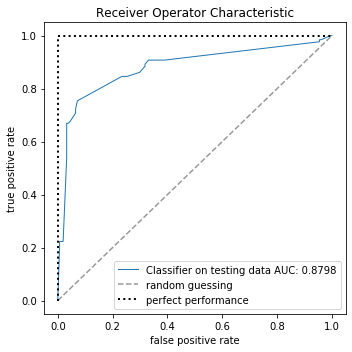

In [105]:
testing_metrics(best_svm, svm_X_test, svm_y_test, best_svm_testing_prediction)

In [106]:
tn, fp, fn, tp = confusion_matrix(svm_y_test, best_svm_testing_prediction).ravel()
(tp, fn, fp, tn)

(93, 37, 10, 144)

### Sensitivity Analysis

In [107]:
sens_svm  = SVC(C = 25,
                        decision_function_shape = 'ovo',
                        gamma = 9.5,
                        kernel = 'linear',
                        random_state = 19,
                        shrinking = True,
                        probability = True)

sens_svm.fit(svm_X_train, svm_y_train)  

sens_svm_training_prediction = sens_svm.predict(svm_X_train)

sens_svm_testing_prediction = sens_svm.predict(svm_X_test)
#snes_svm_testing_prediction

In [108]:
sens_svm

SVC(C=25, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=9.5, kernel='linear',
    max_iter=-1, probability=True, random_state=19, shrinking=True, tol=0.001,
    verbose=False)

Evaluation parameters on training data:


Accuracy: 0.8039
AUC: 0.8039
Precision: 0.8917
Recall: 0.6919
F1: 0.7792


Confusion Matrix
[[327  30]
 [110 247]]


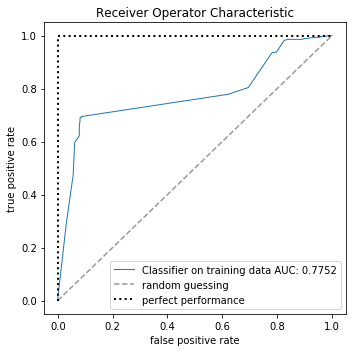

In [109]:
training_metrics(sens_svm, svm_X_train, svm_y_train, sens_svm_training_prediction)

In [110]:
tn, fp, fn, tp = confusion_matrix(svm_y_train, sens_svm_training_prediction).ravel()
(tp, fn, fp, tn)

(247, 110, 30, 327)

Evaluation parameters on testing data:


Accuracy: 0.8345
AUC: 0.8252
Precision: 0.9029
Recall: 0.7154
F1: 0.7983


Confusion Matrix
[[144  10]
 [ 37  93]]


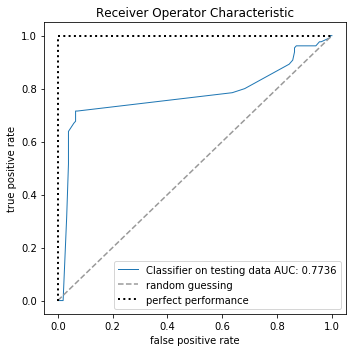

In [111]:
testing_metrics(sens_svm, svm_X_test, svm_y_test, sens_svm_testing_prediction)

In [112]:
tn, fp, fn, tp = confusion_matrix(svm_y_test, sens_svm_testing_prediction).ravel()
(tp, fn, fp, tn)

(93, 37, 10, 144)

In [113]:
sens_svm_1  = SVC(C = 4.9,
                        decision_function_shape = 'ovo',
                        gamma = 25,
                        kernel = 'linear',
                        random_state = 19,
                        shrinking = True,
                        probability = True)

sens_svm_1.fit(svm_X_train, svm_y_train)  

sens_svm_1_training_prediction = sens_svm_1.predict(svm_X_train)

sens_svm_1_testing_prediction = sens_svm_1.predict(svm_X_test)
#snes_svm_testing_prediction

In [114]:
sens_svm_1

SVC(C=4.9, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=25, kernel='linear',
    max_iter=-1, probability=True, random_state=19, shrinking=True, tol=0.001,
    verbose=False)

Evaluation parameters on training data:


Accuracy: 0.8039
AUC: 0.8039
Precision: 0.8917
Recall: 0.6919
F1: 0.7792


Confusion Matrix
[[327  30]
 [110 247]]


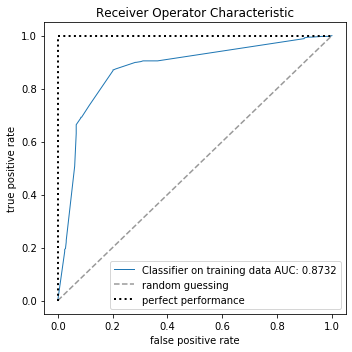

In [115]:
training_metrics(sens_svm_1, svm_X_train, svm_y_train, sens_svm_1_training_prediction)

In [116]:
tn, fp, fn, tp = confusion_matrix(svm_y_train, sens_svm_1_training_prediction).ravel()
(tp, fn, fp, tn)

(247, 110, 30, 327)

Evaluation parameters on testing data:


Accuracy: 0.8345
AUC: 0.8252
Precision: 0.9029
Recall: 0.7154
F1: 0.7983


Confusion Matrix
[[144  10]
 [ 37  93]]


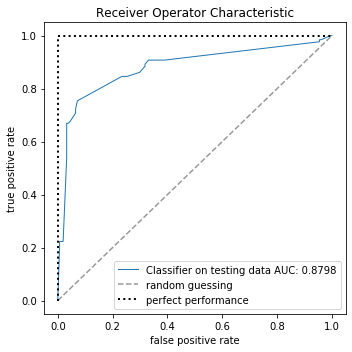

In [117]:
testing_metrics(sens_svm_1, svm_X_test, svm_y_test, sens_svm_1_testing_prediction)

In [118]:
tn, fp, fn, tp = confusion_matrix(svm_y_test, sens_svm_1_testing_prediction).ravel()
(tp, fn, fp, tn)

(93, 37, 10, 144)